**Note:** In order to run this notebook you have to have the GPU accelerator enabled (see notebook on requesting additional computing resources)

In [1]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 437 bytes | 218.00 KiB/s, done.
From https://github.com/lutzhamel/ds-assets
   524299a..8d0b4b7  main       -> origin/main
Updating 524299a..8d0b4b7
Fast-forward
 assets/dsutils.py | 5 +++++
 1 file changed, 5 insertions(+)


In [2]:
if not colab:
  raise Exception("This notebook only executes in the Colab environment")

In [3]:
# notebook level imports
import pandas as pd
import sklearn
import dsutils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set_theme()


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# Natural Language Processing: Deep Learning

[Deep learning](https://en.wikipedia.org/wiki/Deep_learning) is part of a broader family of machine learning methods based on the layers used in artificial neural networks.  Here is how deep learning fits into the broader AI picture,

<img src="https://upload.wikimedia.org/wikipedia/commons/1/18/AI-ML-DL.png" height='500' width='500'>

# Deep Neural Networks

The difference between ANNs and DNNs is the number of hidden layers in the network but also the **different kinds of layers**. The layers in a traditional ANN are called **dense layers** we will see later that deep neural networks are typically composed of additional special purpose layers, e.g.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*7tgDGwjdz9TFsRVCEJROPA.png">

[source](https://srnghn.medium.com/deep-learning-common-architectures-6071d47cb383)

# NLP and Deep Learning

DNNs are particularly well suited for NLP.  But before we look at this application we need to talk about `word embeddings`.

## From Vector Model to Word Embeddings

### The Vector Model

In the [document vector model](https://en.wikipedia.org/wiki/Vector_space_model) of a collection of documents each word that appears in the collection is defined as a dimension in the corresponding vector model giving rise to a docterm-matrix,

<!-- ![](https://ahmedbesbes.com/images/article_5/tfidf.jpg) -->

<!-- ![](https://raw.githubusercontent.com/lutzhamel/fake-news/master/term-doc.jpg) -->

<img src="https://raw.githubusercontent.com/lutzhamel/fake-news/master/term-doc.jpg" height="350" width="450">


### Disadvantages of the Vector Model

The vector representation of documents has two important consequences for document classification problems:

**The order and contexts of words are lost.** To see the importance of the word context consider these [two sentences](https://jair.org/index.php/jair/article/view/11030):

1. “it was not good, it was actually quite bad”, and
2. “it was not bad, it was actually quite good”.  

The vector representation of these sentences is exactly the same but they obviously have very different meanings or classifications.  

In [ ]:
# show the vector models of our two sentences
doc_names = ["sen1", "sen2"]
docs = ["it was not good, it was actually quite bad",
        "it was not bad, it was actually quite good"]

# vector model
dsutils.docterm_matrix(docs, doc_names)

,actually,bad,good,it,not,quite,was
sen1,1,1,1,1,1,1,1
sen2,1,1,1,1,1,1,1


**Semantic similarities between words cannot be represented.** To see the importance of semantic similarity consider,

1. one document that discusses dogs, and
2. another document that discusses puppies.

From a vector model perspective **the feature set for these two documents will not intersect** in terms of the notion of dog because the vector model simply considers dogs and puppies to be two different features.

In [ ]:
# show the vector models of our two sentences
doc_names = ["sen1", "sen2"]
docs = ["puppies like snacks",
        "dog like snacks"]

# vector model
dsutils.docterm_matrix(docs, doc_names)

,dog,like,puppies,snacks
sen1,0,1,1,1
sen2,1,1,0,1


### Word Embeddings

Here words (not documents) are represented as [*embedding vectors*](https://en.wikipedia.org/wiki/Word_embedding) with the idea that two words that are semantically similar to each other have similar vectors. Consider the following figure,


 <img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/Visualization-of-3-dimensional-word-embeddings.png" height="200" width="250"/>

This figure represents a 3D embedding space and we can see that concepts that are similar to each other are close together in this embedding space.  Therefore the similarity of our two documents talking about dogs and puppies is expressed as a "vector simililarity" which is most often computed as the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) rather than comparing features directly,

<img src="http://blog.christianperone.com/wp-content/uploads/2013/09/cosinesimilarityfq1.png" height="200" width="800">

In other words, we are comparing the semantic notion of dogs and puppies rather than the precise syntax of the words.



In [ ]:
import pandas as pd

# our words in 3D embedding space
df = pd.DataFrame({"dog":[0.08,0.31,0.41],
                   "puppy":[0.09,0.35,0.36],
                   "newspaper":[0.59,0.25,0.01]})

print("cosine similarity dog ~ puppy: {:.2f}".format(df['dog'].dot(df['puppy'])))
print("cosine similarity dog ~ newspaper: {:.2f}".format(df['dog'].dot(df['newspaper'])))
print("cosine similarity puppy ~ newspaper: {:.2f}".format(df['puppy'].dot(df['newspaper'])))

cosine similarity dog ~ puppy: 0.26
cosine similarity dog ~ newspaper: 0.13
cosine similarity puppy ~ newspaper: 0.14


One of the more popular word embeddings is [word2vec](https://en.wikipedia.org/wiki/Word2vec) created by Google which embeds words in a 300D vector space.  **Sentences are now represented as a `len x 300` matrix where `len` is the number of words in the sentence and `300` is the embedding dimension**. That is, each word in a sentence is embedded in that 300D space.  The dimensions themselves are "statistical dimensions" where the direction has meaning but the dimensions themselves are unitless.


## Processing Documents for DNNs

Preserving order and context!


In [5]:

tokenizer = Tokenizer()
# train tokenizer - since both sentences contain
# the same words we can train the tokenizer on
# just one of the sentences
tokenizer.fit_on_texts(["it was not good, it was actually quite bad"])
# print sequences
print(tokenizer.texts_to_sequences(["it was not good, it was actually quite bad"])[0])
print(tokenizer.texts_to_sequences(["it was not bad, it was actually quite good"])[0])
# print word index
print(tokenizer.word_index)


[1, 2, 3, 4, 1, 2, 5, 6, 7]
[1, 2, 3, 7, 1, 2, 5, 6, 4]
{'it': 1, 'was': 2, 'not': 3, 'good': 4, 'actually': 5, 'quite': 6, 'bad': 7}


These sequences can be directly fed into a deep neural network for training and classification. Notice that word order and context are nicely preserved in this representation.  This is very different from the Naive Bayes training from our previous NLP applications.

# A Deep Neural Network for Fake-News

The deep neural network we are using for our experiment can be seen here as a Python implementation using the [Keras](https://keras.io) deep learning library,

Get our text data and preprocess it,

In [6]:
# get data
df = pd.read_csv('https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv')
df.head(n=10)

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [7]:
df.shape

(6335, 4)

In [8]:
df['label'].value_counts()

,count
label,
REAL,3171
FAKE,3164


In [9]:
texts = df['text']
texts.head(n=10)

,text
0,"Daniel Greenfield, a Shillman Journalism Fello..."
1,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,U.S. Secretary of State John F. Kerry said Mon...
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
4,It's primary day in New York and front-runners...
5,"\nI’m not an immigrant, but my grandparents ..."
6,"Share This Baylee Luciani (left), Screenshot o..."
7,A Czech stockbroker who saved more than 650 Je...
8,Hillary Clinton and Donald Trump made some ina...
9,Iranian negotiators reportedly have made a las...


In [10]:
# neural network, recode labels as 0 and 1.
labels = df['label'].apply(lambda x: 1 if x == 'FAKE' else 0)

<Axes: xlabel='text', ylabel='Count'>

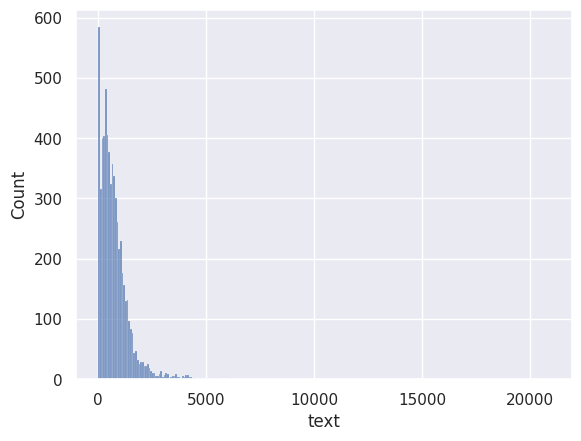

In [11]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
sns.histplot(text_lengths)

From the graph above we see that the majority of documents have 5000 words or less.  Therefore we pick the constant `MAX_SEQUENCE_LENGTH` to be 5000.

In [12]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300

In [13]:
# vectorize the text samples into a 2D integer tensor

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
tok_data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')


print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', tok_data.shape)
print('Shape of label tensor:', labels.shape)

Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [14]:
# split the data into a training and test set

X_train, X_test, y_train, y_test = train_test_split(tok_data,
                                                  labels,
                                                  train_size=0.8,
                                                  test_size=0.2,
                                                  random_state=1)

In [19]:
# build a 1D convnet with global maxpooling

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),

        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Our DNN can be broken down into two distinct parts. The first part consists of three layers and is responsible for  word and sequence processing:
1. The Embedding layer - learn word embeddings.
2. The Convolution layer - learn patterns throughout the text sequences.
3. The Pooling layer - filter out the interesting sequence patterns.

The second part consists of two layers,

1. A Dense layer with a ReLU activation function.
2. A Dense layer (also the output layer) with a Sigmoid activation function.

This part of the DNN can be viewed as a traditional feed-foward, back-propagation neural network with one hidden layer operating on a feature vector of length 128 computed by the first part of the DNN.   In order to see this perhaps a bit clearer, look at the summary of the DNN as compiled by Keras,




The overall structure of the DNN can be understood as a preprocessor defined in the first part that is being trained to map text sequences into feature vectors in such a way that the weights of the second part can be trained to obtain optimal classification results from the overall network.

In [22]:
# train the model

model.fit(X_train,
          y_train,
          batch_size=128,
          epochs=10,
          validation_data=(X_test, y_test))

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5691 - loss: 0.6663 - val_accuracy: 0.8011 - val_loss: 0.4543
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8408 - loss: 0.3784 - val_accuracy: 0.8658 - val_loss: 0.2952
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 881ms/step - accuracy: 0.9234 - loss: 0.2137 - val_accuracy: 0.9242 - val_loss: 0.1863
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 699ms/step - accuracy: 0.9713 - loss: 0.1140 - val_accuracy: 0.9282 - val_loss: 0.1754
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 600ms/step - accuracy: 0.9834 - loss: 0.0630 - val_accuracy: 0.9384 - val_loss: 0.1421
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 521ms/step - accuracy: 0.9969 - loss: 0.0281 - val_accuracy: 0.9211 - val_loss: 0.2096
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 525ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 0.9400 - val_loss: 0.1484
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 495ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 

In [24]:
# Evaluate the model
y_predict = model.predict(X_test).round()
acc = sklearn.metrics.accuracy_score(y_test, y_predict)
lb,ub = dsutils.classification_confint(acc,X_test.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Accuracy: 0.94 (0.93,0.95)


In [28]:
# build the confusion matrix
# FAKE = 1
# REAL = 0
labels = [1,0]
pd.DataFrame(data=sklearn.metrics.confusion_matrix(y_test, y_predict, labels=labels),
                  index=labels,
                  columns=labels)

,1,0
1,594,57
0,19,597
